## MLND Capstone Project
### Quora question pairs 

Find out if a pair of questions are duplicated

In [1]:
#Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from os import path
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter

In [2]:
#Read in training data
train_data_raw = pd.read_csv("train.csv")
train_data_raw.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


Number of training data: 404290
Ratio of duplicate question pairs: 36.920000
Total number of questions: 537933
Number of questions appearing multiple times: 111780


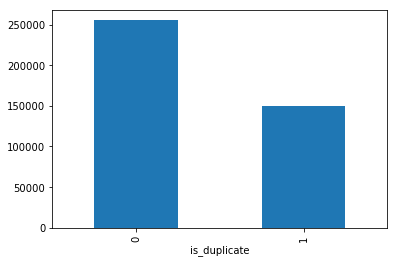

In [3]:
#Look at some statistics of training data
print "Number of training data: %d" %len(train_data_raw)
print "Ratio of duplicate question pairs: %f" %round(train_data_raw['is_duplicate'].mean()*100,2)
qids = pd.Series(train_data_raw['qid1'].tolist() + train_data_raw['qid2'].tolist())
print "Total number of questions: %d" %len(np.unique(qids))
print "Number of questions appearing multiple times: %d" %np.sum(qids.value_counts()>1)
train_data_raw.groupby("is_duplicate")['id'].count().plot.bar()

There are 37% duplicate questions in the training set. We also see that there are many identical questions in the data set. 

In [4]:
#Read in test data and look at the first 5 rows
test_data_raw = pd.read_csv("test.csv")
print "Number of training data: %d" %len(test_data_raw)
test_data_raw.head(5)

Number of training data: 2345796


,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [5]:
#Function to calculate normalized word share between two questions
def word_share_norm(x):
    w1 = set(map(lambda word: word.lower().strip(), str(x['question1']).split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), str(x['question2']).split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

In [6]:
#Construct features for training data: character length, number of words, normalized word share 
train_data = pd.DataFrame(dtype='float64')
train_data['q1chrlen'] = train_data_raw['question1'].str.len()
train_data['q2chrlen'] = train_data_raw['question2'].str.len()
train_data['q1_nword'] = train_data_raw['question1'].apply(lambda x: len(str(x).split(" ")))
train_data['q2_nword'] = train_data_raw['question2'].apply(lambda y: len(str(y).split(" ")))
train_data['word_share'] = train_data_raw.apply(word_share_norm, axis=1)
train_data.head()

,q1chrlen,q2chrlen,q1_nword,q2_nword,word_share
0,66,57.0,14,12,0.434783
1,51,88.0,8,13,0.200000
2,73,59.0,14,10,0.166667
3,50,65.0,11,9,0.000000
4,76,39.0,13,7,0.100000


//anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
//anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


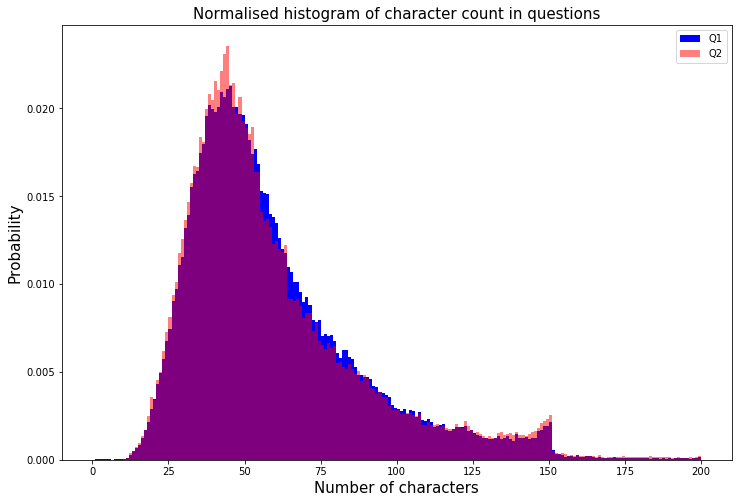

In [7]:
#Get some visual on character count
plt.figure(figsize=(12, 8))
plt.hist(train_data['q1chrlen'], bins=200, range=[0, 200], color='blue', normed=True, label='Q1')
plt.hist(train_data['q2chrlen'], bins=200, range=[0, 200], color='red',alpha = 0.5, normed=True, label='Q2')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

Looks like most questions have about 40-50 characters in them.

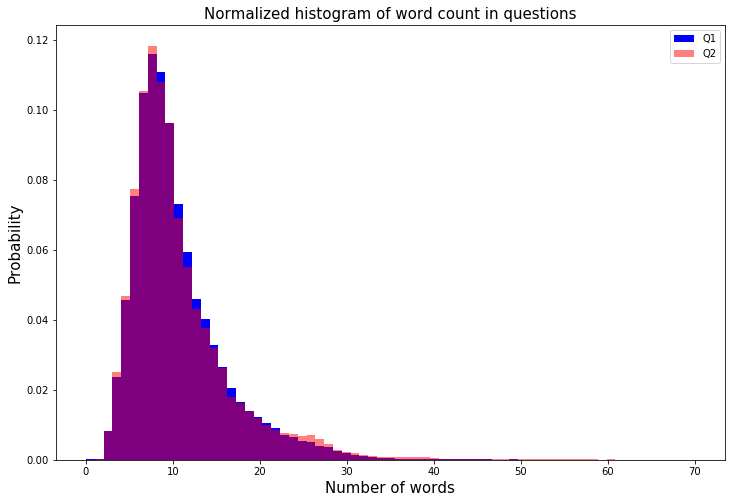

In [8]:
#Get some visual on word count
plt.figure(figsize=(12, 8))
plt.hist(train_data['q1_nword'], bins=np.linspace(0, 70, 70), range=[0, 70], normed = True, color='blue', label='Q1')
plt.hist(train_data['q2_nword'], bins=np.linspace(0, 70, 70), range=[0, 70], normed = True, color='red',alpha = 0.5, label='Q2')
plt.title('Normalized histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

Looks like most questions have about 10 words in them.

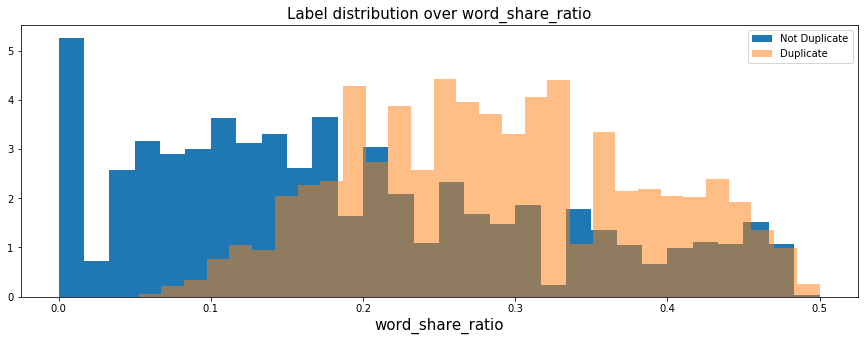

In [9]:
#Get some visual on word share
plt.figure(figsize=(15, 5))
train_word_share = train_data['word_share']
plt.hist(train_word_share[train_data_raw['is_duplicate'] == 0], bins=30, normed=True, label='Not Duplicate')
plt.hist(train_word_share[train_data_raw['is_duplicate'] == 1], bins=30, normed=True, alpha=0.5, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_share_ratio', fontsize=15)
plt.xlabel('word_share_ratio', fontsize=15)

In [10]:
#Combine all questions into corpus for TFIDF analysis
train_questions = pd.Series(train_data_raw['question1'].tolist() + train_data_raw['question2'].tolist()).astype(str)
test_questions = pd.Series(test_data_raw['question1'].tolist() + test_data_raw['question2'].tolist()).astype(str)
#Implement TFIDF function
def get_weight(count, eps=5000, min_count=2):
    if count < min_count:
        return 0 #remove words only appearing once 
    else:
        R = 1.0 / (count + eps)
        return R

eps = 5000 
words = (" ".join(train_questions)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}
print "Most common words: ", (sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])

Most common words:  [('the', 2.623060902228028e-06), ('what', 3.164927538983995e-06), ('is', 3.651647440742891e-06), ('how', 4.463907079310237e-06), ('i', 4.5832664940302954e-06), ('a', 4.646127684881036e-06), ('to', 4.783155639101341e-06), ('in', 5.006909535158519e-06), ('of', 6.100834594172483e-06), ('do', 6.260956674179815e-06)]


In [11]:
#Calculate TFIDF word match share as our new feature
def tfidf_word_share_norm(x):
    w1 = set(map(lambda word: word.lower().strip(), str(x['question1']).split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), str(x['question2']).split(" "))) 
    if len(w1)==0 or len(w2)==0:
        return 0
    common = w1 & w2
    share_weight = [weights.get(word, 0) for word in common]
    total_weight = [weights.get(word, 0) for word in w1]+[weights.get(word, 0) for word in w2]
    return np.sum(share_weight)/np.sum(total_weight)
train_data['TFIDF_share'] = train_data_raw.apply(tfidf_word_share_norm, axis=1, raw=True)

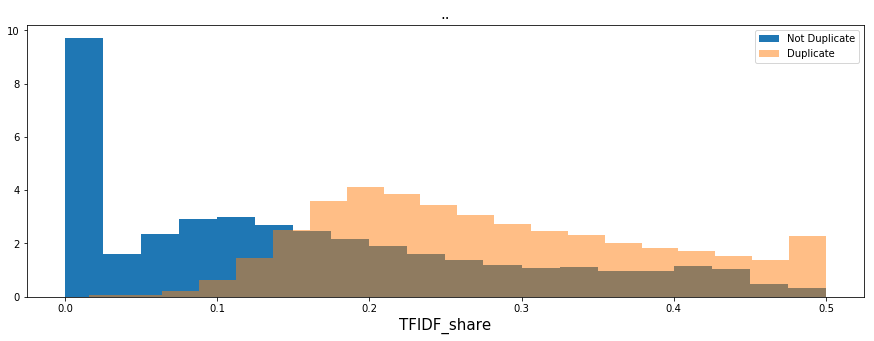

In [12]:
#Get some visual on TFIDF word share
plt.figure(figsize=(15, 5))
train_tfidf = train_data['TFIDF_share'].fillna(0)
plt.hist(train_tfidf[train_data_raw['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_tfidf[train_data_raw['is_duplicate'] == 1], bins=20, normed=True, alpha=0.5, label='Duplicate')
plt.legend()
plt.title('..', fontsize=15)
plt.xlabel('TFIDF_share', fontsize=15)

As one would expect, the word share ratio is higher for duplicate question pairs.

(-0.5, 1279.5, 979.5, -0.5)

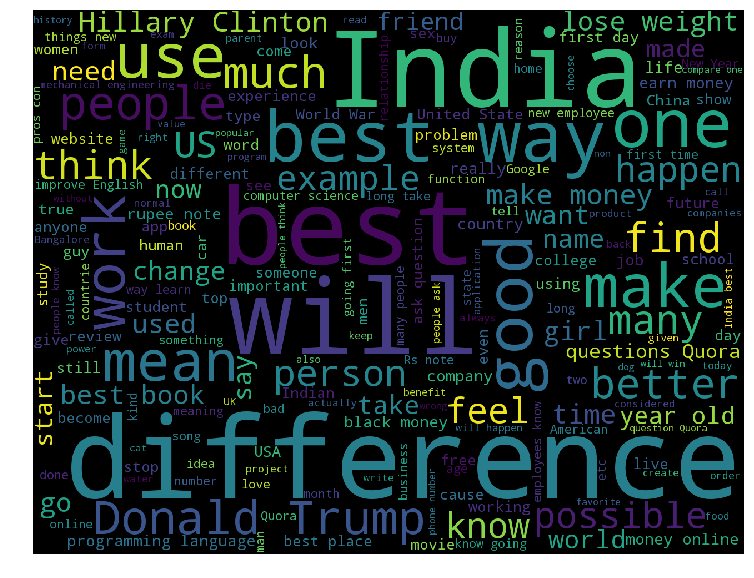

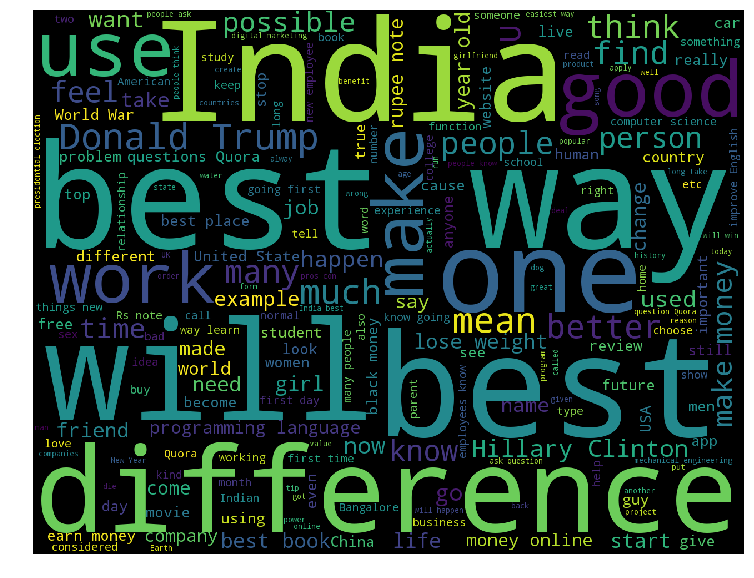

In [13]:
#Check out the most common words in word cloud
cloud1 = WordCloud(width=1280, height=980).generate(" ".join(train_data_raw['question1'].astype(str)))
cloud2 = WordCloud(width=1280, height=980).generate(" ".join(train_data_raw['question2'].astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud1)
plt.axis('off')
plt.figure(figsize=(15, 10))
plt.imshow(cloud2)
plt.axis('off')

Two word clouds generated from question 1 and question 2 show that there are a few duplicate most common words in them.

In [38]:
#Split training data to train and validation data sets
label = train_data_raw['is_duplicate']
X_train, X_valid, y_train, y_valid = train_test_split(train_data, label, test_size=0.2, random_state=10)

In [42]:
#Check if there's NaN values in the data. If yes, replace them.
np.sum(np.isnan(X_train))
X_train.loc[:,'q2chrlen'] = np.nan_to_num(X_train.loc[:,'q2chrlen'])
np.sum(np.isnan(X_train))

q1chrlen       0
q2chrlen       0
q1_nword       0
q2_nword       0
word_share     0
TFIDF_share    0
dtype: int64

In [67]:
#Normalized feature values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.fit_transform(X_valid)

In [68]:
#Benchmark model : random forest
rfc = RandomForestClassifier(max_depth=5, random_state=0)
rfc.fit(X_train_scaled,y_train)
prediction = rfc.predict(X_valid_scaled)
score_rfc = rfc.score(X_valid_scaled, y_valid)
print score_rfc

0.72073264241


In [71]:
#Test data feature extraction
test_data = pd.DataFrame()
test_data['q1chrlen'] = test_data_raw['question1'].str.len()
test_data['q2chrlen'] = test_data_raw['question2'].str.len()
test_data['q1_nword'] = test_data_raw['question1'].apply(lambda x: len(str(x).split(" ")))
test_data['q2_nword'] = test_data_raw['question2'].apply(lambda y: len(str(y).split(" ")))
test_data['word_share'] = test_data_raw.apply(word_share_norm, axis=1)
test_data['TFIDF_share'] = test_data_raw.apply(tfidf_word_share_norm, axis=1, raw=True)
#Replace NaN
np.sum(np.isnan(test_data))
test_data.loc[:,['q1chrlen','q2chrlen']] = np.nan_to_num(test_data.loc[:,['q1chrlen','q2chrlen']])
np.sum(np.isnan(test_data))
#Normalize
test_data_scaled = scaler.fit_transform(test_data)

In [18]:
#Test submission for Kaggle competition
sub = pd.DataFrame({'test_id': test_data_raw['test_id'], 'is_duplicate': rfc.predict(test_data)})
sub.to_csv('rfc_submission.csv', index=False)

In [70]:
#Model1: Logistic regression model
#Use GridSearch cross validation to find best parameter
lr = LogisticRegression(random_state=10)
grid = {
    'C': [1e-6, 1e-3, 1e0, 1e3, 1e6],
    'penalty': ['l1', 'l2']
}
cv = GridSearchCV(lr, grid, scoring='neg_log_loss', verbose = True)
cv.fit(X_train_scaled, y_train)
print cv.best_params_
score_lr = cv.best_estimator_.score(X_valid_scaled, y_valid)
print "Logistic regression accuracy: %f" %score_lr

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   25.1s finished


{'penalty': 'l1', 'C': 1000000.0}
Logistic regression accuracy: 0.669161


In [72]:
#Test submission for Kaggle competition
lr = LogisticRegression(C = 1000000, penalty = 'l1', random_state=10)
lr.fit(X_train_scaled, y_train)
prediction = lr.predict(test_data_scaled)
sub = pd.DataFrame({'test_id': test_data_raw['test_id'], 'is_duplicate': prediction})
sub.to_csv('lr_submission.csv', index=False)

In [51]:
#Model2: Decision tree 
dt = DecisionTreeClassifier(max_depth = 100, random_state=10)
dt.fit(X_train, y_train)
prediction = dt.predict(X_valid)
score_dt = dt.score(X_valid, y_valid)
print "Decision tree accuracy: %f" %score_dt

Decision tree accuracy: 0.695738


In [58]:
#Test submission for Kaggle competition
sub = pd.DataFrame({'test_id': test_data_raw['test_id'], 'is_duplicate': dt.predict(test_data)})
sub.to_csv('dt_submission.csv', index=False)

In [73]:
#Model3: SVM model
svm = SVC(random_state=0, max_iter=500)
svm.fit(X_train_scaled, y_train)
score_svm = svm.score(X_valid_scaled, y_valid)
print "SVM accuracy: %f" %score_svm

SVM accuracy: 0.569084


In [66]:
#Test submission for Kaggle competition
X_test_scaled = scaler.fit_transform(test_data)
sub = pd.DataFrame({'test_id': test_data_raw['test_id'], 'is_duplicate': svm.predict(X_test_scaled)})
sub.to_csv('svm_submission.csv', index=False)

In [77]:
#Model4: K Nearest Neighbors
knn = KNeighborsClassifier()
grid = {
    'n_neighbors': list(range(2, 10, 2)),
    'weights': ['uniform', 'distance']
}
cv = GridSearchCV(knn, grid, scoring='neg_log_loss', verbose = True)
cv.fit(X_train_scaled, y_train)
print cv.best_params_
score_knn = cv.best_estimator_.score(X_valid_scaled, y_valid)
print "KNN accuracy: %f" %score_knn

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  4.9min finished


{'n_neighbors': 8, 'weights': 'uniform'}
KNN accuracy: 0.719335


In [76]:
#Test submission for Kaggle competition
knn = KNeighborsClassifier(n_neighbors = 8, weights = 'uniform')
knn.fit(X_train_scaled, y_train)
prediction = knn.predict(test_data_scaled)
sub = pd.DataFrame({'test_id': test_data_raw['test_id'], 'is_duplicate': prediction})
sub.to_csv('knn_submission.csv', index=False)

In [75]:
#Naive Bayes model
mnb = MultinomialNB().fit(X_train, y_train)
score_nb = mnb.score(X_valid,y_valid)
print "NB accuracy: %f" %score_nb 

NB accuracy: 0.632689


In [61]:
#Test submission for Kaggle competition
sub = pd.DataFrame({'test_id': test_data_raw['test_id'], 'is_duplicate': mnb.predict(test_data)})
sub.to_csv('nb_submission.csv', index=False)

So far, SVM gets the best leaderboard score, but only top 90%. I think I need more features from TFIDF vectors other than just word match share. 

In [ ]:
#Let's get TFIDF vector from each question 